Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# We import all the needed libraries for the CNN algorithm

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [2]:
#Supress warnings
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train=pathlib.Path('/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test=pathlib.Path('/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2241
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)

Found 2241 files belonging to 9 classes.
Using 1793 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123,
                                                               subset="validation",
                                                               validation_split=0.2)


Found 2241 files belonging to 9 classes.
Using 448 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print('Total Classes',len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Classes 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

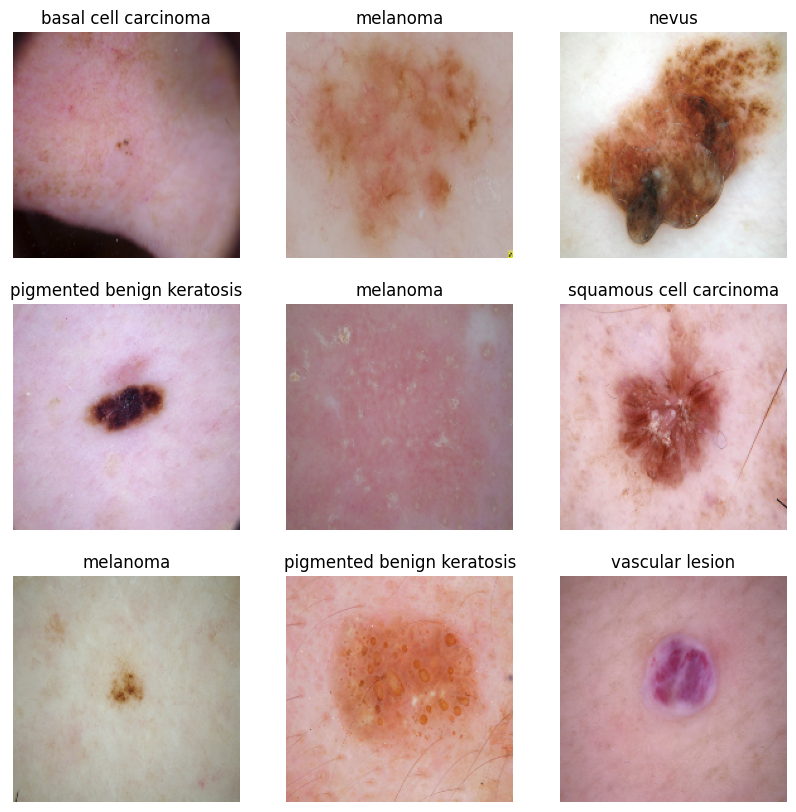

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model [1st model]
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# Convulation Layer - 1
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu', input_shape = (img_height, img_width, batch_size)))
# Convulation Layer - 2
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convulation Layer - 3
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))

# Convulation Layer - 4
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flatten
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

# Dense with Softmax
model.add(Dense(num_classes, activation = "softmax"))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                        

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 196s 786ms/step - loss: 2.4364 - accuracy: 0.2404 - val_loss: 2.0081 - val_accuracy: 0.2812
Epoch 2/20
57/57 [==============================] - 4s 67ms/step - loss: 1.9228 - accuracy: 0.2833 - val_loss: 1.7956 - val_accuracy: 0.3571
Epoch 3/20
57/57 [==============================] - 4s 66ms/step - loss: 1.6757 - accuracy: 0.3971 - val_loss: 2.0658 - val_accuracy: 0.2723
Epoch 4/20
57/57 [==============================] - 4s 66ms/step - loss: 1.6039 - accuracy: 0.4244 - val_loss: 1.5930 - val_accuracy: 0.3973
Epoch 5/20
57/57 [==============================] - 4s 68ms/step - loss: 1.4850 - accuracy: 0.4635 - val_loss: 1.5942 - val_accuracy: 0.4397
Epoch 6/20
57/57 [==============================] - 4s 66ms/step - loss: 1.4516 - accuracy: 0.4824 - val_loss: 1.6240 - val_accuracy: 0.4420
Epoch 7/20
57/57 [==============================] - 4s 66ms/step - loss: 1.4177 - accuracy: 0.4992 - val_loss: 1.6888 - val_accuracy: 0.4598
Epoch 8/20

### Visualizing training results

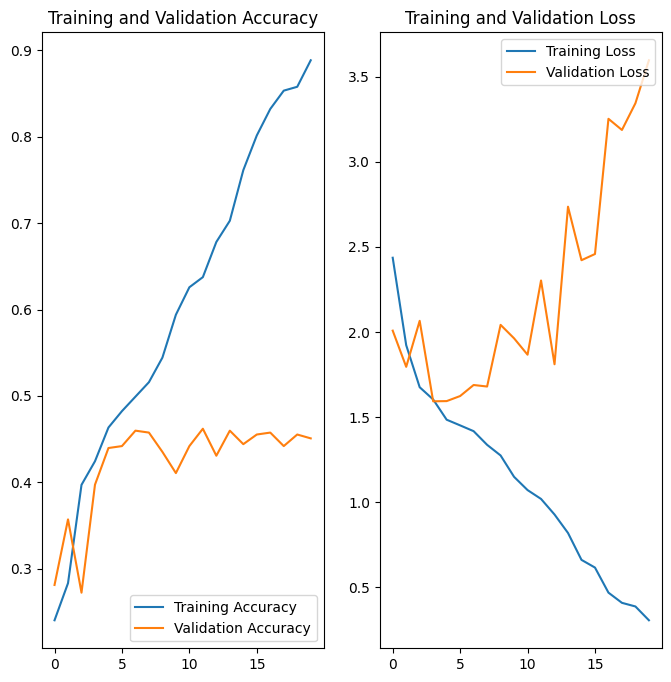

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

> From the visualization below, at first the accuracy of training and validation are increasing together in the first epochs
But as the epochs increased, the accuracy for validation increased slowly. This was the case of overfitting

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_aug = tf.keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='nearest'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

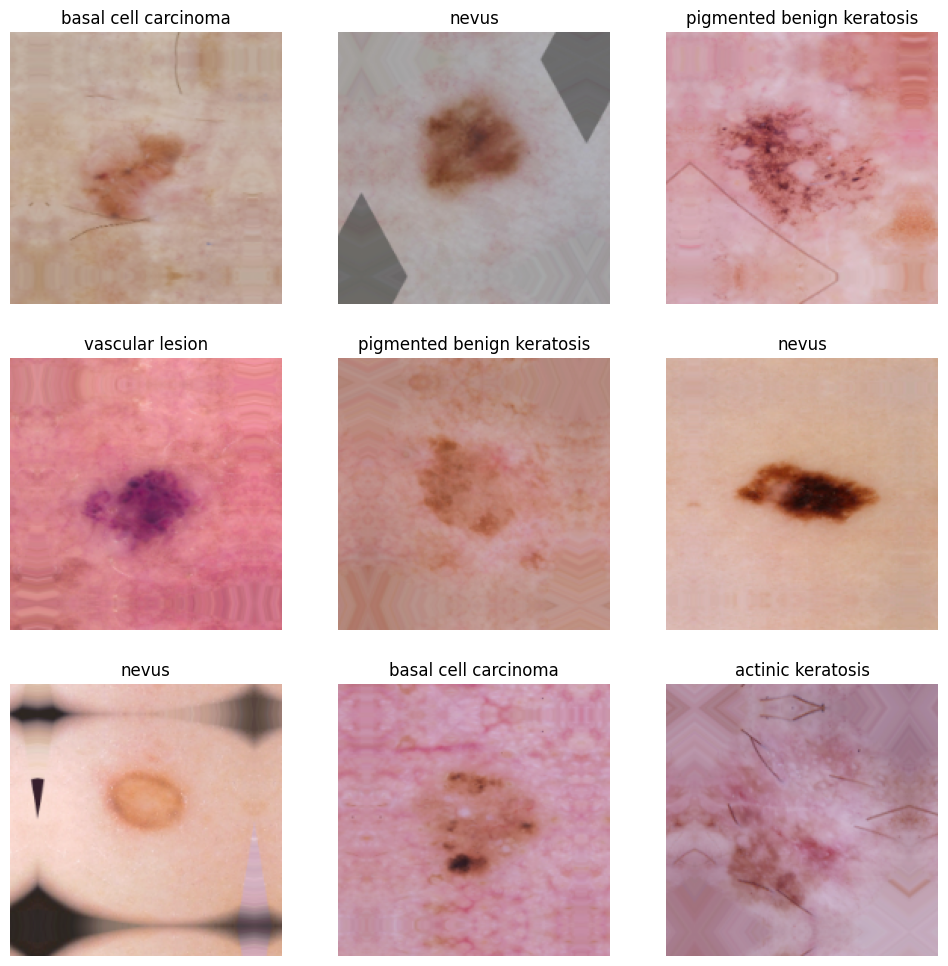

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model [2nd model]


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model = Sequential([data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# Convulation Layer - 1
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu', input_shape = (img_height, img_width, batch_size)))
# Convulation Layer - 2
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convulation Layer - 3
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))

# Convulation Layer - 4
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# Dense with Softmax
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [20]:
## Your code goes here
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
# Setting CheckPoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 2.4405 - accuracy: 0.1952
Epoch 1: val_accuracy improved from -inf to 0.17411, saving model to model.h5
57/57 [==============================] - 10s 114ms/step - loss: 2.4405 - accuracy: 0.1952 - val_loss: 2.0770 - val_accuracy: 0.1741
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 2.0433 - accuracy: 0.2136
Epoch 2: val_accuracy improved from 0.17411 to 0.23661, saving model to model.h5
57/57 [==============================] - 6s 113ms/step - loss: 2.0433 - accuracy: 0.2136 - val_loss: 1.9615 - val_accuracy: 0.2366
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.9868 - accuracy: 0.2471
Epoch 3: val_accuracy improved from 0.23661 to 0.30357, saving model to model.h5
57/57 [==============================] - 6s 106ms/step - loss: 1.9868 - accuracy: 0.2471 - val_loss: 1.8927 - val_accuracy: 0.3036
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 1.9362 - accurac

### Visualizing the results

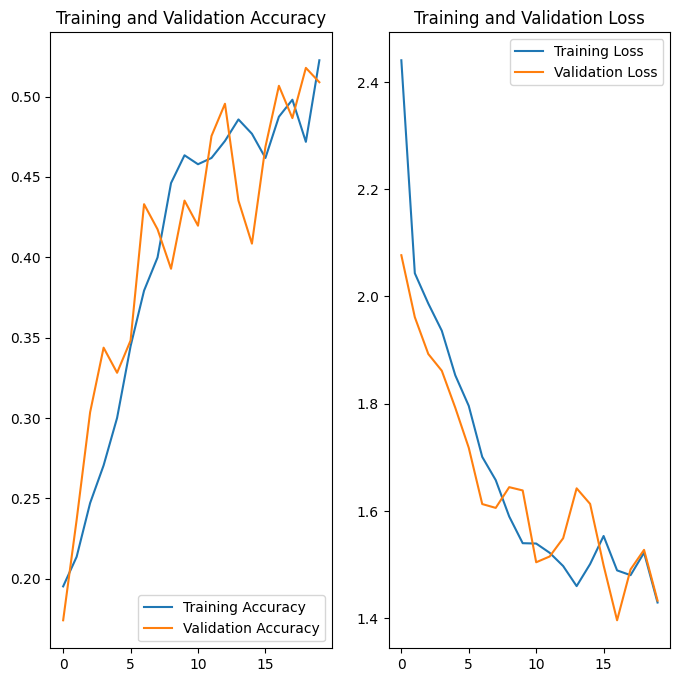

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

> We can clearly see the gap between training accuracy and validation accuracy has decreased meaning overfitting is reduced as compared to previous run. But overall accuracy has also gone down as compared to previous run.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

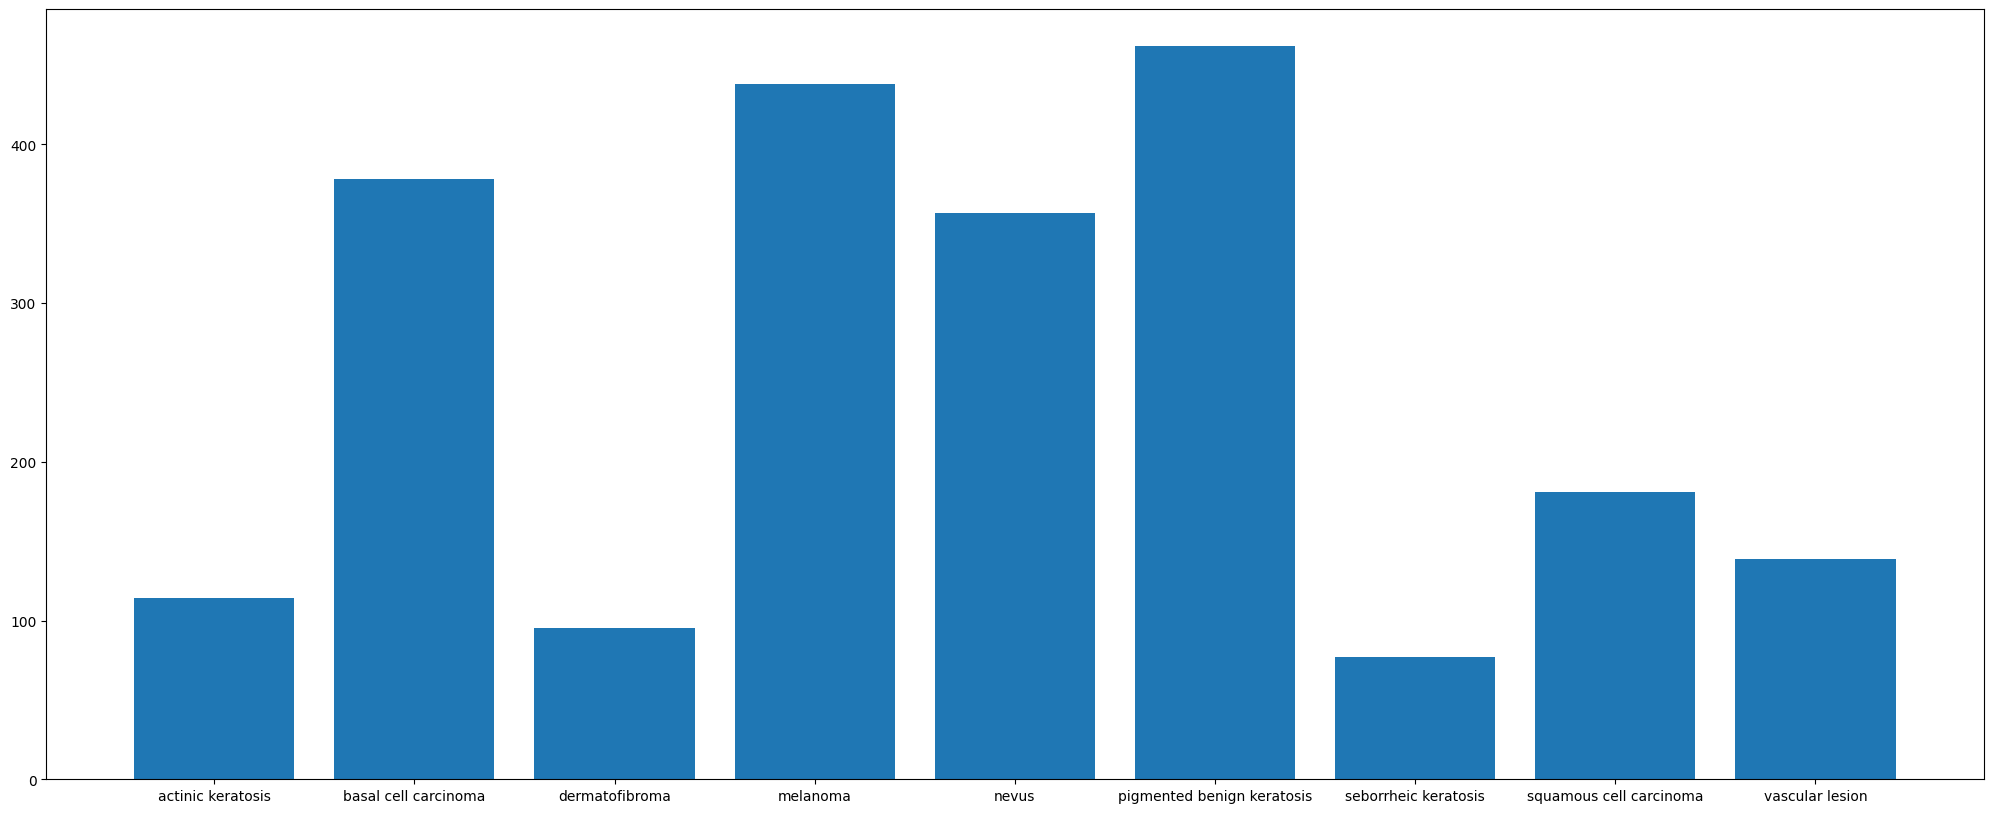

In [23]:
## Your code goes here.
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

In [24]:
## Lets get the number of sample details in a dataframe and analyse whether there is imbalance between / across classes

path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_org = dict(zip(path_list, lesion_list))
org_df =pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])
org_df


,Path,Label
0,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,actinic keratosis
1,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,actinic keratosis
2,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,actinic keratosis
3,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,actinic keratosis
4,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,actinic keratosis
...,...,...
2236,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,vascular lesion
2237,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,vascular lesion
2238,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,vascular lesion
2239,/content/gdrive/MyDrive/ML/Skin cancer ISIC Th...,vascular lesion


In [25]:
# See the count of images to see if there is imbalance
org_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          378
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
> class "seborrheic keratosis" has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
> Classes "melanoma" and "pigmented benign keratosis" dominate in terms of proprtionate number of samples, with high number of samples when compared to the rest of the Classes.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
# Using Augmentor to rectify the imbalance
path_to_training_dataset="/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795D8A427E50>: 100%|██████████| 500/500 [00:29<00:00, 16.91 Samples/s]


Initialised with 378 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795E201CE680>: 100%|██████████| 500/500 [00:30<00:00, 16.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795D8A56AD40>: 100%|██████████| 500/500 [00:27<00:00, 18.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x795E295EADD0>: 100%|██████████| 500/500 [01:58<00:00,  4.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795D8A5C3730>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795D965F16F0>: 100%|██████████| 500/500 [00:23<00:00, 21.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x795D8A48D150>: 100%|██████████| 500/500 [00:57<00:00,  8.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795E201CC190>: 100%|██████████| 500/500 [00:25<00:00, 19.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x795D8A405D20>: 100%|██████████| 500/500 [00:23<00:00, 21.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011039.jpg_626a3342-3836-4f00-a0c6-63c93e5e10f1.jpg',
 '/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010423.jpg_6433a611-4c58-43fe-8207-1f86aaaf159e.jpg',
 '/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_fbfd7046-f385-4e18-a678-a629c2c95805.jpg',
 '/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011112.jpg_c50091db-d479-44c7-b9b7-4b8538c913e0.jpg',
 '/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001108.jpg_498fb5f1-9b0d-4051-8d1e-602e650f01e5.jpg',
 '/content/gdrive/MyDrive/ML/Skin cancer ISIC

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [33]:
new_df['Label'].value_counts()

melanoma                      500
vascular lesion               500
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/content/gdrive/MyDrive/ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


#### **Todo:** Create your model (make sure to include normalization) [3rd model]

In [37]:
## your code goes here
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# Convulation Layer - 1
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu', input_shape = (img_height, img_width, batch_size)))
model.add(BatchNormalization())
# Convulation Layer - 2
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# Convulation Layer - 3
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())

# Convulation Layer - 4
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# Dense with Softmax
model.add(Dense(num_classes, activation = "softmax"))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 63s 324ms/step - loss: 4.2358 - accuracy: 0.1411 - val_loss: 60.3383 - val_accuracy: 0.0705
Epoch 2/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1867 - accuracy: 0.1446 - val_loss: 60.7722 - val_accuracy: 0.1231
Epoch 3/30
169/169 [==============================] - 50s 288ms/step - loss: 2.1815 - accuracy: 0.1435 - val_loss: 4.5669 - val_accuracy: 0.1469
Epoch 4/30
169/169 [==============================] - 46s 264ms/step - loss: 2.1787 - accuracy: 0.1437 - val_loss: 2.2190 - val_accuracy: 0.1358
Epoch 5/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1972 - accuracy: 0.1441 - val_loss: 122.5624 - val_accuracy: 0.1358
Epoch 6/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1785 - accuracy: 0.1435 - val_loss: 2.1867 - val_accuracy: 0.1395
Epoch 7/30
169/169 [==============================] - 45s 262ms/step - loss: 2.1762 - accuracy: 0.1435 - val_loss: 2.1869 - va

#### **Todo:**  Visualize the model results

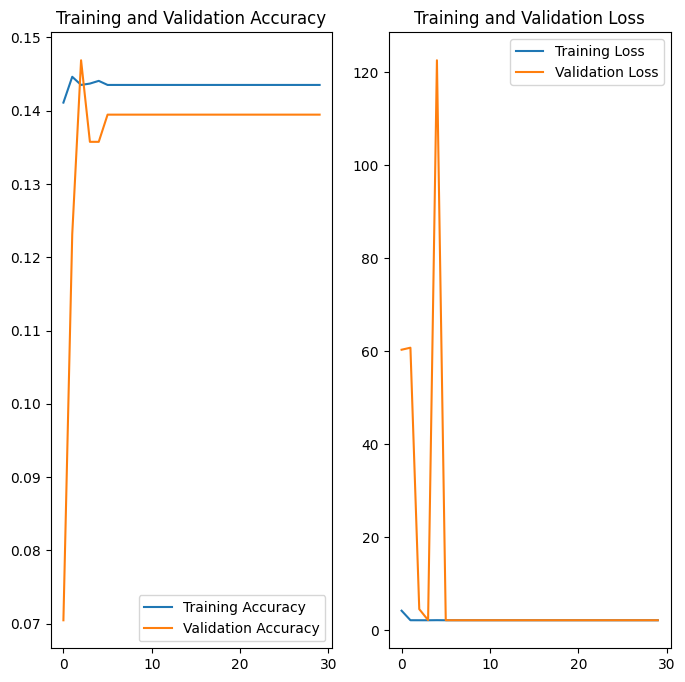

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



> The model accuracy after 30 epoch on training is aroung 80 and for val it is 71. So the model does not look to overfit. Also the accuracy have improved which resolved the underfitting issue. So, Yes, class rebalance helped to improve the model.